In [127]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [54]:
path = '~/Downloads/Misc/lfw/lfw'

In [55]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,), batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([3, 250, 250])
torch.Size([250, 250, 3])


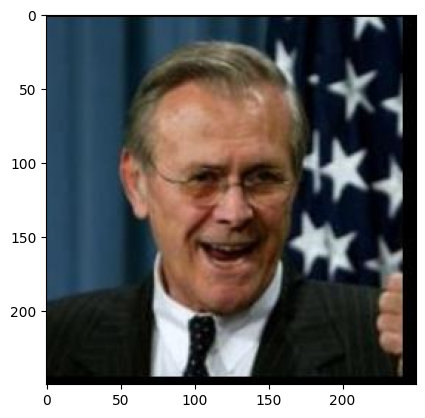

In [16]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [6]:
for x,y in dataloader:
    print(x.shape)
    # 32 images per batch, each image is 250 by 250 with 3 color channels
    print(x[0].shape)
    # Individual image taken from batch
    break

torch.Size([32, 3, 250, 250])
torch.Size([3, 250, 250])


# Step 3

Create a new pytorch model class for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [98]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE,self).__init__()

        # x comes in: b, 3, 250, 250
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 15),  # b, 8, 236, 236
            nn.ReLU(True),
            nn.Conv2d(8, 8, 12, stride=2),  # b, 8, 113, 113
            nn.Conv2d(8, 16, 15, stride=2),  # b, 16, 52, 52
            nn.ReLU(True),
            nn.Conv2d(16, 8, 15, stride=2), # b, 4, 19, 19
            nn.ReLU(True),
            nn.Conv2d(8, 4, 15), # b, 4, 5, 5
            nn.ReLU(True),
            nn.Conv2d(4, 2, 1) # b, 2, 4, 4
        )

        # encoding comes in: b, 2, 4, 4
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 6, 15),  # b, 6, 18, 18
            nn.ReLU(True),
            nn.ConvTranspose2d(6, 12, 15, stride=2),  # b, 12, 49, 49
            nn.Tanh(),
            nn.ConvTranspose2d(12, 6, 25, stride=2),  # b, 6, 121, 121
            nn.ReLU(True),
            nn.ConvTranspose2d(6, 3, 10, stride=2), # b, 3, 250, 250
            nn.Tanh()
        )
        
    def encode(self,x):
        return self.encoder(x)
        
    def decode(self,x):
        return self.decoder(x)
        
    def forward(self,x):
        return self.decoder(self.encoder(x))
       

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [99]:
model = AE()

In [100]:
for x,y in dataloader:
    image = x[0]
    print(image.shape)
    encoded = model.encode(image)
    print(encoded.shape)
    decoded = model.decode(encoded)
    print(decoded.shape)
    break

torch.Size([3, 250, 250])
torch.Size([2, 4, 4])
torch.Size([3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [101]:
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Params: 145197


In [102]:
learning_rate = 1e-3
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [103]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [104]:
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, _ = data

        # ===================forward=====================
        
        output = model(img)
        loss = loss_function(output, img)
        
        # ===================backward====================
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.data
        
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))
# if loss is not decreasing, you can revise your model and ensure that the loss and optimization functions are being called at each step.

epoch [1/10], loss:31.9602
epoch [2/10], loss:29.8591
epoch [3/10], loss:29.7792
epoch [4/10], loss:29.7211
epoch [5/10], loss:29.6895
epoch [6/10], loss:29.7310
epoch [7/10], loss:29.6456
epoch [8/10], loss:29.6812
epoch [9/10], loss:29.6690
epoch [10/10], loss:29.6403


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

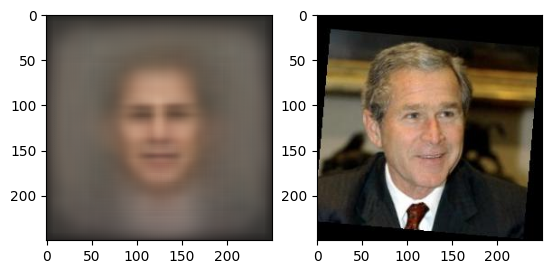

In [220]:
img = None
for x,y in dataloader:
    img = x[15,:,:,:]
    break
output = model(img)
output = output.detach().cpu().squeeze().permute(1, 2, 0)
plt.subplot(121)
plt.imshow(output)
plt.subplot(122)
plt.imshow(img.permute(1,2,0))

##  Step 8

In step 7, add a small normaly distributed noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

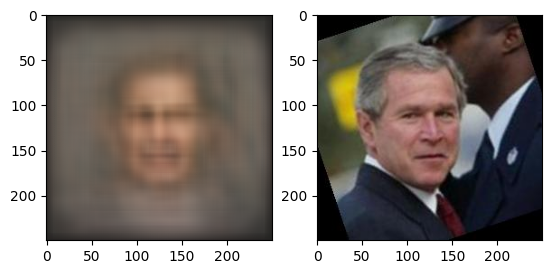

In [219]:
img = None
for x,y in dataloader:
    img = x[15,:,:,:]
    break
encoding = model.encode(img)
encoding += torch.randn(encoding.shape) / 4
output = model.decoder(encoding)

output = output.detach().cpu().squeeze().permute(1, 2, 0)
plt.subplot(121)
plt.imshow(output)
plt.subplot(122)
plt.imshow(img.permute(1,2,0))
# I feel the normally distributed noise added after encoding, makes the features more extreme. That is, it makes the perceived features of the face more
# obviously reflected in the resulting decoding. Previously, all faces kind of decoded to the same face, probably as a result of training finding that
# the one standard face was the best option to consistently achieve a low loss. But with the added noise, the faces generated can more closely match the
# input.